In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import torchvision

from config import (
    get_device,
)

print(torch.__version__)
print(torchvision.__version__)


DEVICE: torch.device = get_device()

2.10.0+cu128
0.25.0+cu128
Using DEVICE: cuda


In [3]:
from utils import download_stl10
from config import IMAGE_DIMENSION_STL, IMAGE_DIMENSION

train_dataset, test_dataset = download_stl10(img_dimensions=IMAGE_DIMENSION)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

STL-10 ready  train=5000  test=8000  channels=3

Dataset Statistics:
Training samples: 5000
Testing samples: 8000
Number of classes: 10
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [4]:
from utils import get_data_loaders
from config import BATCH_SIZE, DEFAULT_SEED

train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset,
    train_dataset=train_dataset,
    batch_size=BATCH_SIZE,
    manual_seed=DEFAULT_SEED,
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


DataLoader Information:
Train batches: 79
Test batches: 125


In [5]:
from utils import set_seed
from models import HalkaNet
from config import BranchType, FilterType

set_seed(seed=DEFAULT_SEED)

model_stl_train = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    filter_channels=18,
    filters=[FilterType.LOG, FilterType.LBP],
    tail_depth=1,
)

In [6]:
from utils import print_model_summary

print_model_summary(model=model_stl_train, img_dim=IMAGE_DIMENSION_STL)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 64, 64]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 64, 64]            [1, 1, 64, 64]            (3)                       12,288
├─Sequential: 1-2                                       [1, 3, 64, 64]            [1, 32, 16, 16]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 64, 64]            [1, 16, 64, 64]           48                        196,608
│    └─BatchNorm2d: 2-2                                 [1, 16, 64, 64]           [1, 16, 64, 64]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    └─DepthwiseConv: 2-4

In [7]:
from config import BranchType, CHECKPOINT_DIR, EPOCHS_PRO_MAX, WEIGHT_DECAY, LABEL_SMOOTHING
from utils import run_experiment

results = run_experiment(
    halkanet=model_stl_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_STL,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=True,
    checkpoint_dir=f"{CHECKPOINT_DIR}/stl-10_96x96_models",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 76,676 params | Dataset: 5,000 samples | base_lr: 2e-03
Warmup: 8 epochs → peak 2e-03 | Cosine: 92 epochs → 1.6e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 4.25e-04
  Epoch   3: 6.50e-04
  Epoch   4: 8.75e-04
  Epoch   5: 1.10e-03
  Epoch   9: 2.00e-03
  Epoch  98: 6.24e-06
  Epoch  99: 3.33e-06
  Epoch 100: 1.58e-06
EMA decay: 0.9975  (≈5-epoch window, 395 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00043
  Train  Acc: 23.08%  Loss: 2.1673
  Test   Acc: 12.25%  Loss: 2.3616
Best saved (Test Acc: 12.25%)
-----------------------------------
Epoch   2/100 | LR: 0.00065
  Train  Acc: 34.16%  Loss: 1.8790
  Test   Acc: 13.75%  Loss: 2.2818
Best saved (Test Acc: 13.75%)
-----------------------------------
Epoch   3/100 | LR: 0.00088
  Train  Acc: 40.66%  Loss: 1.7411
  Test   Acc: 20.11%  Loss: 2.2426
Best saved (Test Acc: 20.11%)
-----------------------------------
Epoch   4/100 | LR: 0.00110
  

In [8]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               82.15% 98.55%     76,679      17.9      0.26    4.02   248.6  ◄
  ShuffleNetV2-0.5×      71.85% 96.76%    352,042       3.2      1.41    5.60   178.5
  MobileNetV2-0.35×      72.05% 97.26%    408,938       4.8      1.64    4.88   205.1
  SqueezeNet-1.1         65.30% 97.25%    727,626      17.2      2.91    1.80   554.6
  MobileNetV3-Small      72.47% 97.46%  1,528,106       5.5      6.11    4.68   213.6
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 82.15% Top-1 | 76,679 params | 4.02 ± 0.54 ms | 248.6 FPS



Saved → ../figure/train_stl-10_96x96_comparision.pdf / .png


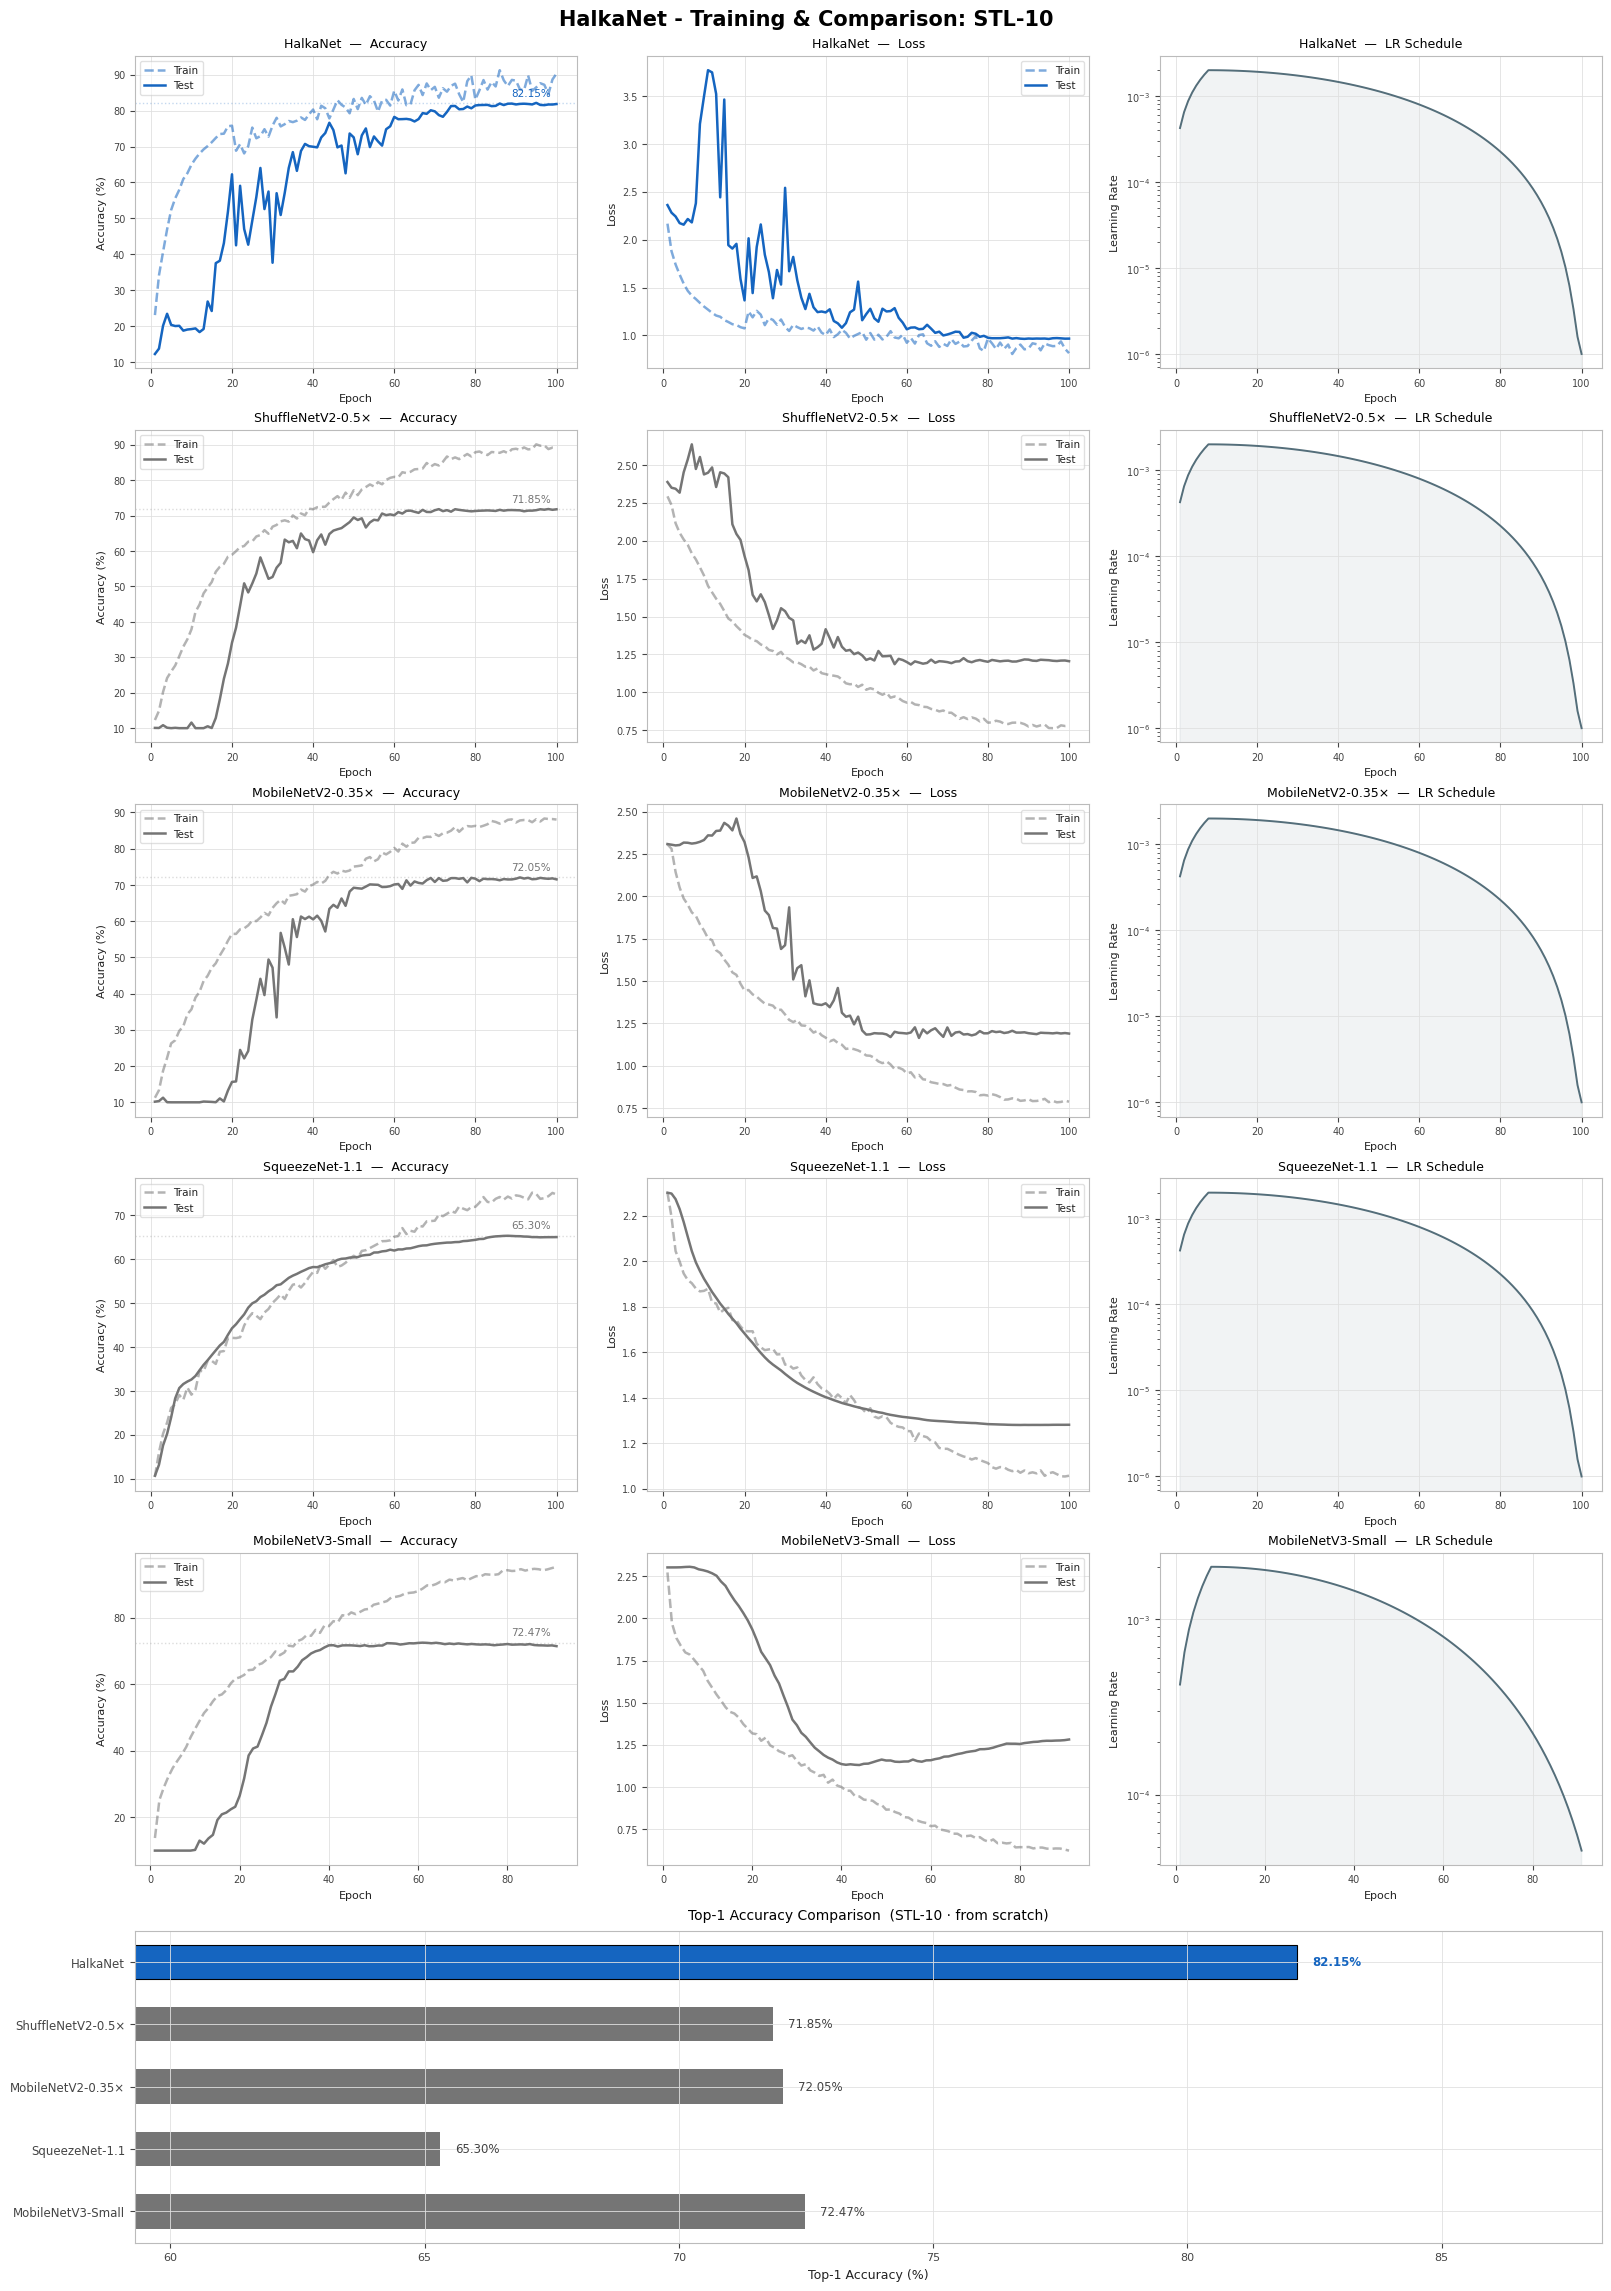

In [9]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/train_stl-10_96x96_comparision.pdf",
    dataset_name="STL-10",
)

In [10]:
from utils import cleanup

cleanup(results, train_dataset, test_dataset, train_dataloader, test_dataloader, class_names, data_channel)

CUDA  Allocated 43.4 MB  Reserved 98.6 MB


In [11]:
from utils import download_intel
from config import IMAGE_DIMENSION_INTEL

train_dataset, test_dataset = download_intel(img_dimensions=IMAGE_DIMENSION_INTEL)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


Intel ready  train=14034  test=3000  channels=3

Dataset Statistics:
Training samples: 14034
Testing samples: 3000
Number of classes: 6
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [12]:
from utils import get_data_loaders
from config import BATCH_SIZE, DEFAULT_SEED

train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset,
    train_dataset=train_dataset,
    batch_size=BATCH_SIZE,
    manual_seed=DEFAULT_SEED,
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


DataLoader Information:
Train batches: 220
Test batches: 47


In [13]:
from utils import set_seed
from models import HalkaNet
from config import BranchType, FilterType


set_seed(seed=DEFAULT_SEED)

model_intel_train = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1},
    filter_channels=18,
    filters=[FilterType.LOG, FilterType.LBP, FilterType.WAVE],
    tail_depth=1,
)

In [14]:
from utils import print_model_summary

print_model_summary(model=model_intel_train, img_dim=IMAGE_DIMENSION_INTEL)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 96, 96]            [1, 6]                    --                        --
├─Conv2d: 1-1                                           [1, 3, 96, 96]            [1, 1, 96, 96]            (3)                       27,648
├─Sequential: 1-2                                       [1, 3, 96, 96]            [1, 40, 24, 24]           --                        --
│    └─Conv2d: 2-1                                      [1, 3, 96, 96]            [1, 16, 96, 96]           48                        442,368
│    └─BatchNorm2d: 2-2                                 [1, 16, 96, 96]           [1, 16, 96, 96]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 96, 96]           [1, 16, 96, 96]           --                        --
│    └─DepthwiseConv: 2-4

In [15]:
from config import (
    CHECKPOINT_DIR,
    EPOCHS_PRO_MAX,
    WEIGHT_DECAY,
    LABEL_SMOOTHING,
)
from utils import run_experiment

results = run_experiment(
    halkanet=model_intel_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_INTEL,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=True,
    checkpoint_dir=f"{CHECKPOINT_DIR}/intel_96x96_models",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 88,351 params | Dataset: 14,034 samples | base_lr: 2e-03
Warmup: 8 epochs → peak 2e-03 | Cosine: 92 epochs → 1.6e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 4.25e-04
  Epoch   3: 6.50e-04
  Epoch   4: 8.75e-04
  Epoch   5: 1.10e-03
  Epoch   9: 2.00e-03
  Epoch  98: 6.24e-06
  Epoch  99: 3.33e-06
  Epoch 100: 1.58e-06
EMA decay: 0.9991  (≈5-epoch window, 1100 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00043
  Train  Acc: 61.99%  Loss: 1.2552
  Test   Acc: 20.05%  Loss: 1.8090
Best saved (Test Acc: 20.05%)
-----------------------------------
Epoch   2/100 | LR: 0.00065
  Train  Acc: 78.18%  Loss: 0.9040
  Test   Acc: 32.28%  Loss: 1.6501
Best saved (Test Acc: 32.28%)
-----------------------------------
Epoch   3/100 | LR: 0.00088
  Train  Acc: 82.87%  Loss: 0.8075
  Test   Acc: 47.43%  Loss: 1.5796
Best saved (Test Acc: 47.43%)
-----------------------------------
Epoch   4/100 | LR: 0.00110


In [16]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               91.83% 99.73%     88,354      46.9      0.30    6.93   144.2  ◄
  ShuffleNetV2-0.5×      87.67% 98.93%    347,942       7.3      1.39    6.15   162.5
  MobileNetV2-0.35×      87.83% 99.60%    403,814      10.7      1.62    6.50   153.9
  SqueezeNet-1.1         88.70% 99.77%    725,574      43.2      2.90    3.01   331.7
  MobileNetV3-Small      88.67% 99.33%  1,524,006      11.1      6.10    4.92   203.3
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 91.83% Top-1 | 88,354 params | 6.93 ± 0.61 ms | 144.2 FPS



Saved → ../figure/train_intel_96x96_comparision.pdf / .png


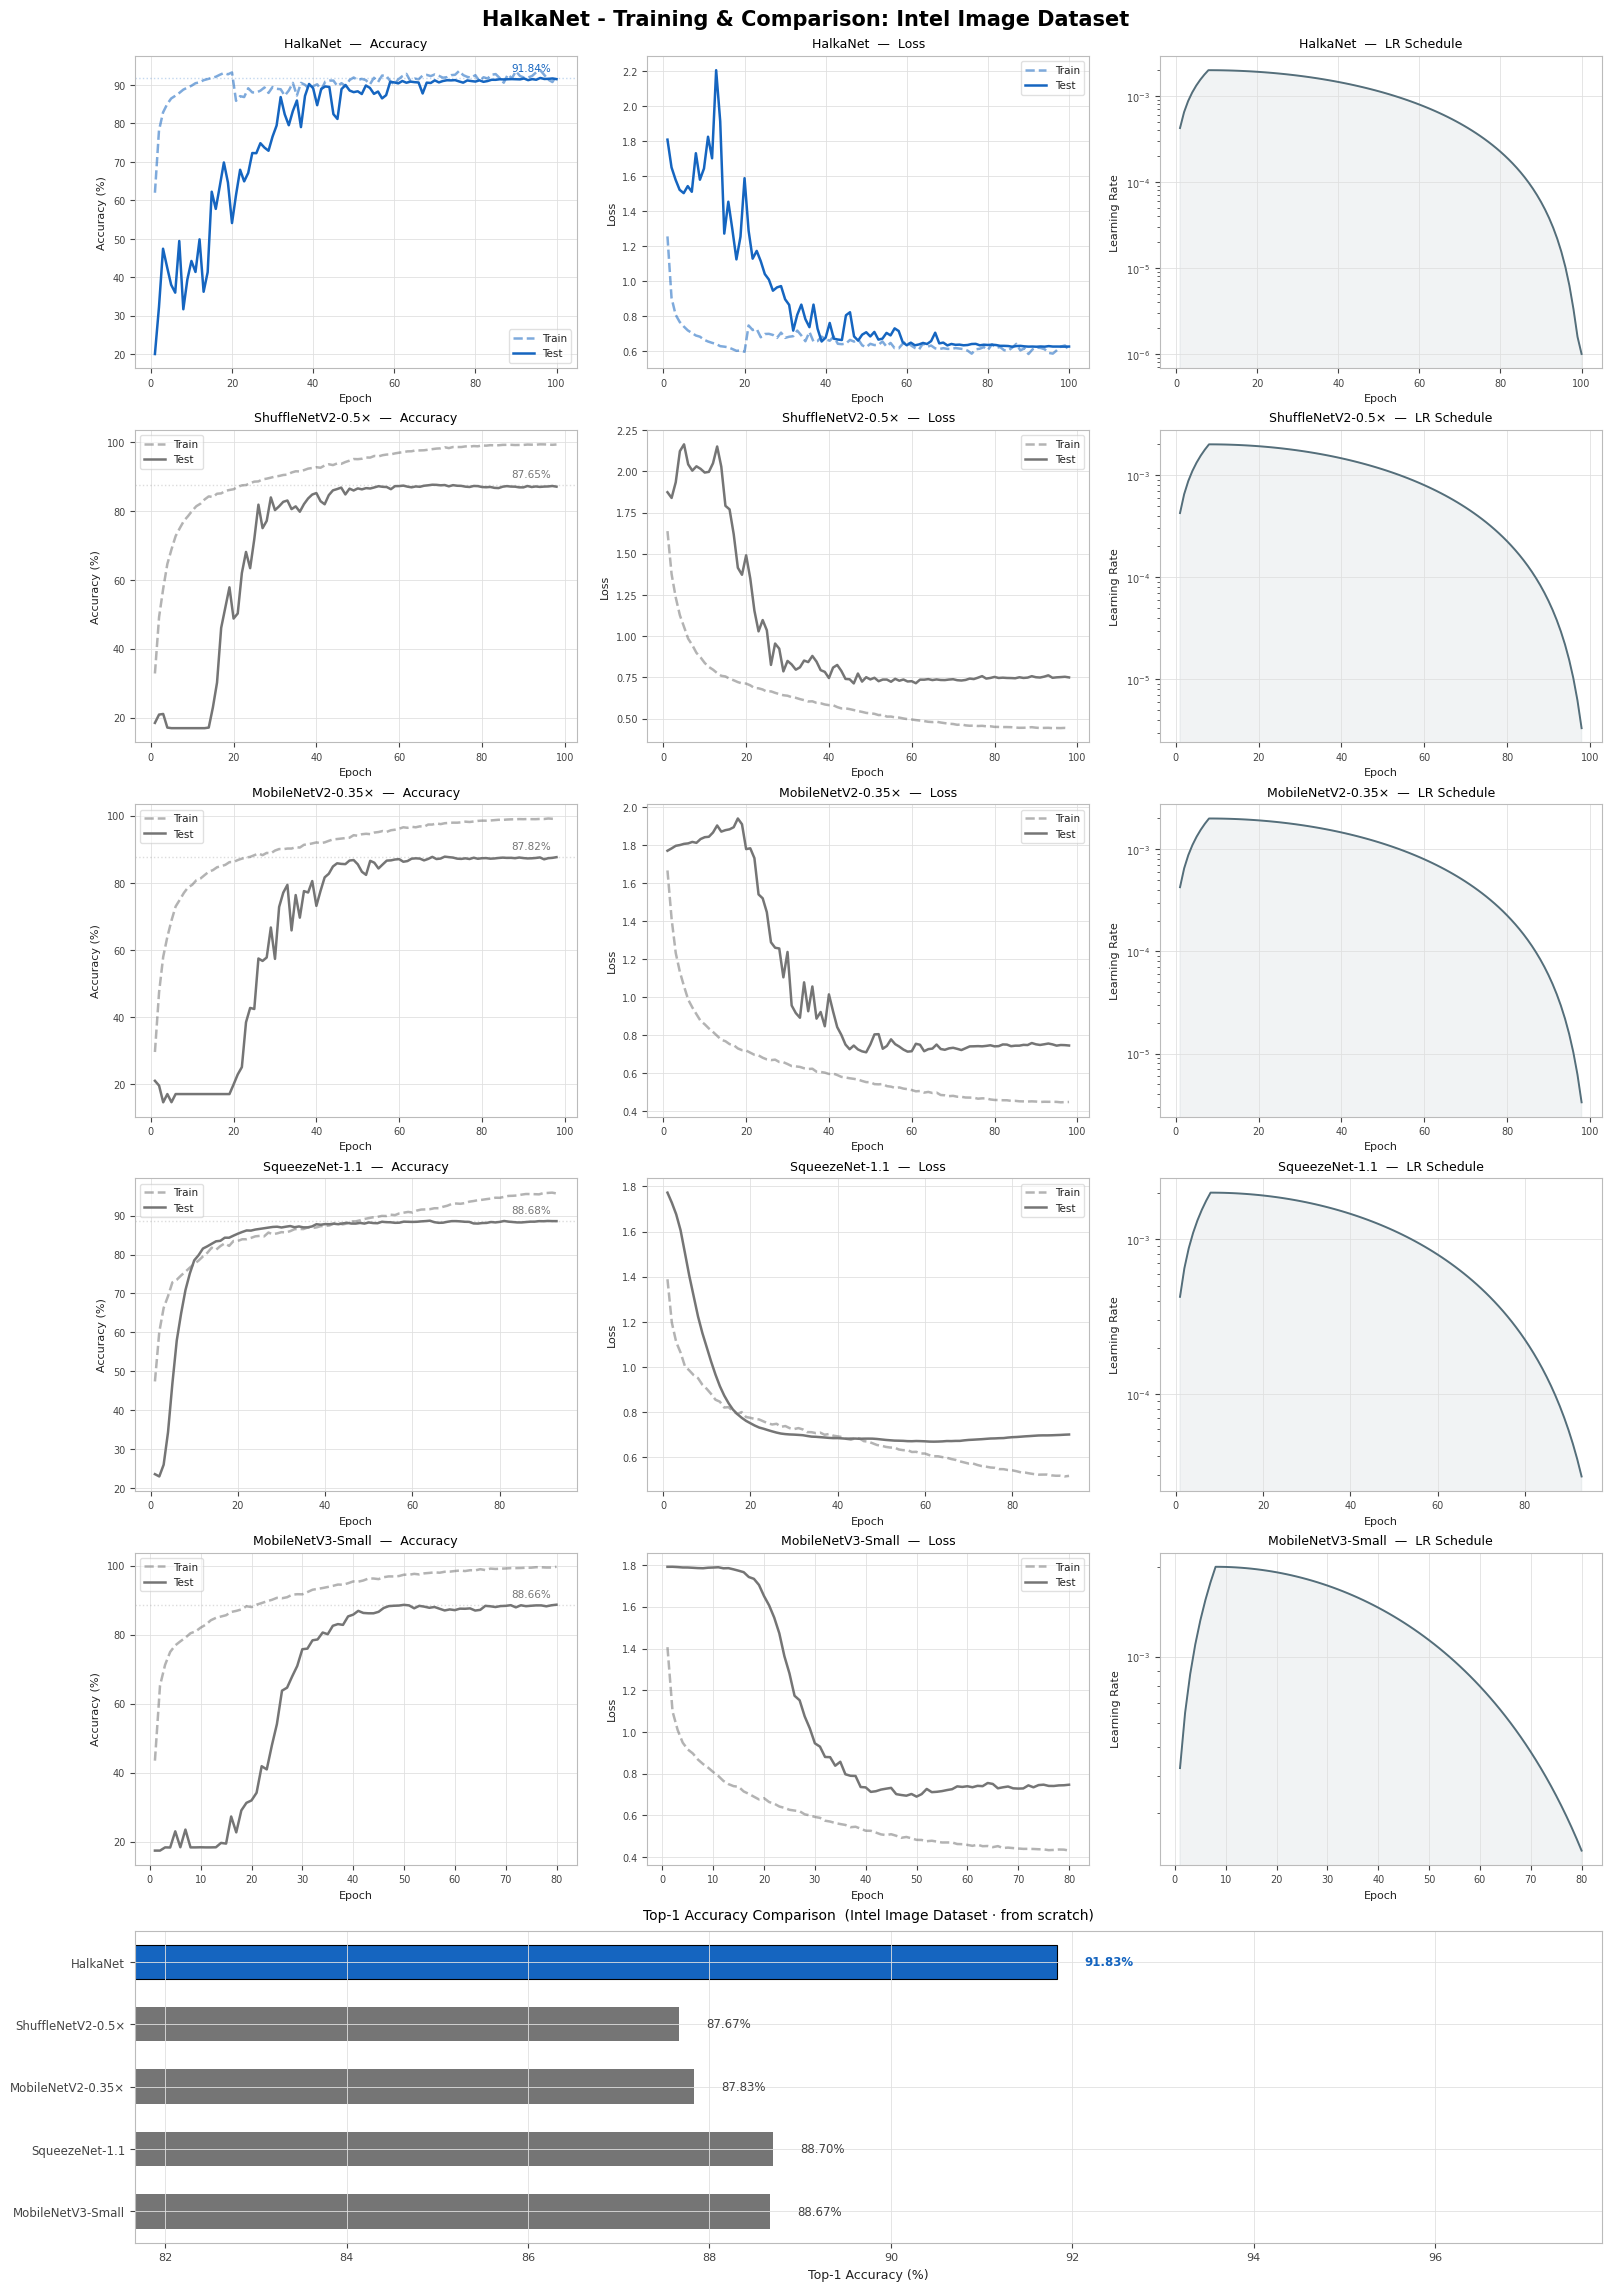

In [17]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/train_intel_96x96_comparision.pdf",
    dataset_name="Intel Image Dataset",
)


In [18]:
from utils import cleanup

cleanup(
    results,
    train_dataset,
    test_dataset,
    train_dataloader,
    test_dataloader,
    class_names,
    data_channel,
)


CUDA  Allocated 44.0 MB  Reserved 115.3 MB


In [19]:
from utils import download_cifar10
from config import IMAGE_DIMENSION_CIFAR

train_dataset, test_dataset = download_cifar10(img_dimensions=IMAGE_DIMENSION_CIFAR)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


CIFAR-10 ready  train=50000  test=10000  channels=3

Dataset Statistics:
Training samples: 50000
Testing samples: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [20]:
from utils import get_data_loaders
from config import BATCH_SIZE, DEFAULT_SEED

train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset,
    train_dataset=train_dataset,
    batch_size=BATCH_SIZE,
    manual_seed=DEFAULT_SEED,
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


DataLoader Information:
Train batches: 782
Test batches: 157


In [21]:
from utils import set_seed
from models import HalkaNet
from config import BranchType, FilterType

set_seed(seed=DEFAULT_SEED)

model_cifar10_train = HalkaNet(
    num_classes=len(class_names),
    rgb_stem_channels=16,
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1.5},
    filter_channels=22,
    filters=[FilterType.LBP, FilterType.LOG, FilterType.GABOR, FilterType.WAVE],
    # tail_depth=2,
)

In [22]:
from utils import print_model_summary

print_model_summary(model=model_cifar10_train, img_dim=IMAGE_DIMENSION_CIFAR)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 32, 32]            [1, 1, 32, 32]            (3)                       3,072
├─Sequential: 1-2                                       [1, 3, 32, 32]            [1, 40, 8, 8]             --                        --
│    └─Conv2d: 2-1                                      [1, 3, 32, 32]            [1, 16, 32, 32]           48                        49,152
│    └─BatchNorm2d: 2-2                                 [1, 16, 32, 32]           [1, 16, 32, 32]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 32, 32]           [1, 16, 32, 32]           --                        --
│    └─DepthwiseConv: 2-4  

In [23]:
from config import (
    CHECKPOINT_DIR,
    EPOCHS_PRO_MAX,
    WEIGHT_DECAY,
    LABEL_SMOOTHING,
)
from utils import run_experiment

results = run_experiment(
    halkanet=model_cifar10_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_CIFAR,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=False,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=True,
    checkpoint_dir=f"{CHECKPOINT_DIR}/cifar10_32x32_models",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 155,988 params | Dataset: 50,000 samples | base_lr: 3e-03
Warmup: 8 epochs → peak 3e-03 | Cosine: 92 epochs → 1.9e-06
LR preview:
  Epoch   1: 3.00e-04
  Epoch   2: 6.38e-04
  Epoch   3: 9.75e-04
  Epoch   4: 1.31e-03
  Epoch   5: 1.65e-03
  Epoch   9: 3.00e-03
  Epoch  98: 8.86e-06
  Epoch  99: 4.50e-06
  Epoch 100: 1.87e-06
EMA decay: 0.9997  (≈5-epoch window, 3910 steps)

Starting 100 epochs (patience=30) | CutMix: OFF

Epoch   1/100 | LR: 0.00064
  Train  Acc: 47.30%  Loss: 1.6402
  Test   Acc: 11.16%  Loss: 2.3479
Best saved (Test Acc: 11.16%)
-----------------------------------
Epoch   2/100 | LR: 0.00098
  Train  Acc: 62.52%  Loss: 1.3366
  Test   Acc: 12.36%  Loss: 2.3691
Best saved (Test Acc: 12.36%)
-----------------------------------
Epoch   3/100 | LR: 0.00131
  Train  Acc: 68.74%  Loss: 1.2111
  Test   Acc: 13.49%  Loss: 2.5435
Best saved (Test Acc: 13.49%)
-----------------------------------
Epoch   4/100 | LR: 0.00165
  Train  Acc: 72.38%  Lo

In [24]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)



────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               89.50% 99.38%    155,991       9.0      0.53    3.09   323.5  ◄
  ShuffleNetV2-0.5×      76.45% 97.84%    352,042       0.8      1.41    4.81   207.8
  MobileNetV2-0.35×      80.16% 98.89%    408,938       1.2      1.64    4.28   233.4
  SqueezeNet-1.1         21.63% 64.23%    727,626       3.0      2.91    1.14   877.2
  MobileNetV3-Small      78.81% 98.53%  1,528,106       2.2      6.11    5.01   199.7
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 89.50% Top-1 | 155,991 params | 3.09 ± 0.31 ms | 323.5 FPS



Saved → ../figure/train_cifar10_32x32_comparision.pdf / .png


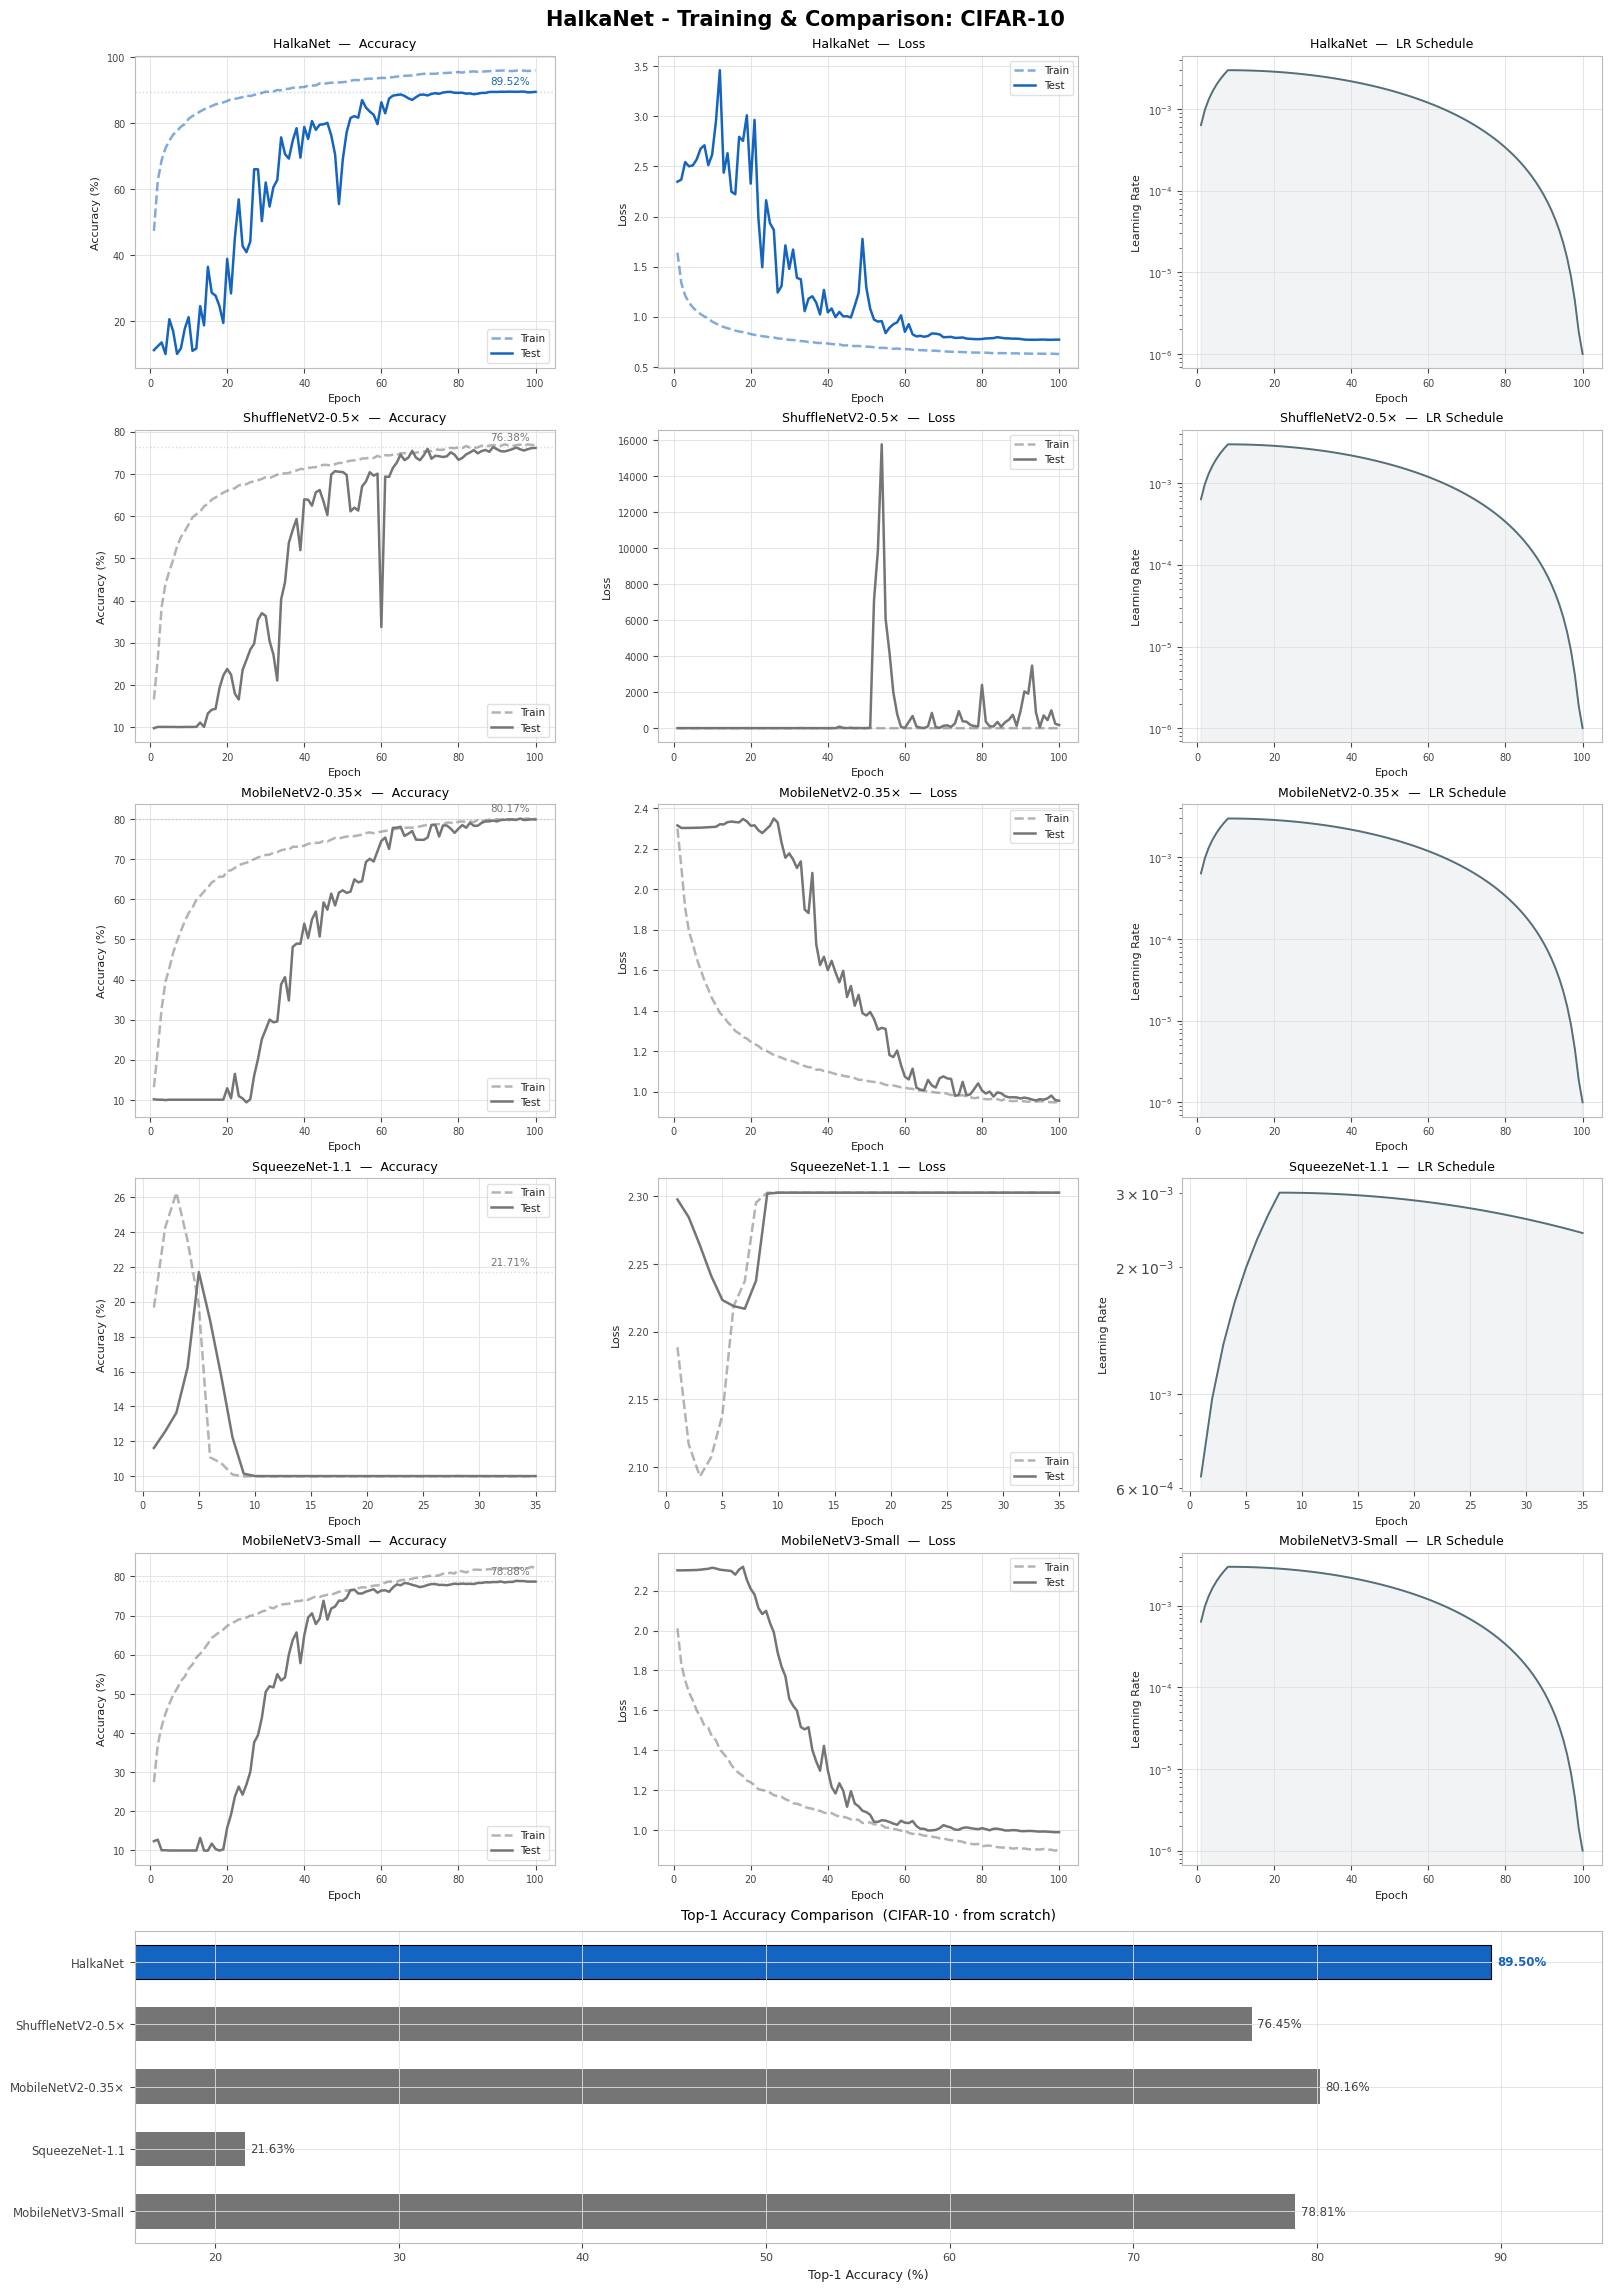

In [25]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/train_cifar10_32x32_comparision.pdf",
    dataset_name="CIFAR-10",
)


In [26]:
from utils import cleanup

cleanup(
    results,
    train_dataset,
    test_dataset,
    train_dataloader,
    test_dataloader,
    class_names,
    data_channel,
)

CUDA  Allocated 45.4 MB  Reserved 130.0 MB


In [27]:
from utils import download_cifar100
from config import IMAGE_DIMENSION_CIFAR

train_dataset, test_dataset = download_cifar100(img_dimensions=IMAGE_DIMENSION_CIFAR)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


CIFAR-100 ready  train=50000  test=10000  channels=3

Dataset Statistics:
Training samples: 50000
Testing samples: 10000
Number of classes: 100
Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',

In [28]:
from utils import get_data_loaders
from config import BATCH_SIZE, DEFAULT_SEED

train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset,
    train_dataset=train_dataset,
    batch_size=BATCH_SIZE,
    manual_seed=DEFAULT_SEED,
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


DataLoader Information:
Train batches: 782
Test batches: 157


In [29]:
from utils import set_seed
from models import HalkaNet
from config import BranchType, FilterType

set_seed(seed=DEFAULT_SEED)

model_cifar100_train = HalkaNet(
    num_classes=len(class_names),
    rgb_stem_channels=16,
    filter_channels=17,
    filters=[FilterType.LBP, FilterType.LOG, FilterType.GABOR, FilterType.WAVE],
    skip_expansion={BranchType.RGB: 1, BranchType.FILTER: 1},
    tail_depth=3,
    tail_grow_ratio=0.6,
)


In [30]:
from utils import print_model_summary

print_model_summary(model=model_cifar100_train, img_dim=IMAGE_DIMENSION_CIFAR)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 32, 32]            [1, 100]                  --                        --
├─Conv2d: 1-1                                           [1, 3, 32, 32]            [1, 1, 32, 32]            (3)                       3,072
├─Sequential: 1-2                                       [1, 3, 32, 32]            [1, 32, 8, 8]             --                        --
│    └─Conv2d: 2-1                                      [1, 3, 32, 32]            [1, 16, 32, 32]           48                        49,152
│    └─BatchNorm2d: 2-2                                 [1, 16, 32, 32]           [1, 16, 32, 32]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 32, 32]           [1, 16, 32, 32]           --                        --
│    └─DepthwiseConv: 2-4  

In [31]:
from config import (
    CHECKPOINT_DIR,
    EPOCHS_PRO_MAX,
    WEIGHT_DECAY,
    LABEL_SMOOTHING,
)
from utils import run_experiment

results = run_experiment(
    halkanet=model_cifar100_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_CIFAR,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=True,
    checkpoint_dir=f"{CHECKPOINT_DIR}/cifar100_32x32_models",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 160,222 params | Dataset: 50,000 samples | base_lr: 3e-03
Warmup: 8 epochs → peak 3e-03 | Cosine: 92 epochs → 1.9e-06
LR preview:
  Epoch   1: 3.00e-04
  Epoch   2: 6.38e-04
  Epoch   3: 9.75e-04
  Epoch   4: 1.31e-03
  Epoch   5: 1.65e-03
  Epoch   9: 3.00e-03
  Epoch  98: 8.86e-06
  Epoch  99: 4.50e-06
  Epoch 100: 1.87e-06
EMA decay: 0.9997  (≈5-epoch window, 3910 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00064
  Train  Acc: 11.55%  Loss: 4.0300
  Test   Acc: 1.88%  Loss: 4.6145
Best saved (Test Acc: 1.88%)
-----------------------------------
Epoch   2/100 | LR: 0.00098
  Train  Acc: 23.35%  Loss: 3.4018
  Test   Acc: 2.87%  Loss: 4.5718
Best saved (Test Acc: 2.87%)
-----------------------------------
Epoch   3/100 | LR: 0.00131
  Train  Acc: 31.65%  Loss: 3.0564
  Test   Acc: 2.16%  Loss: 4.5467
-----------------------------------
Epoch   4/100 | LR: 0.00165
  Train  Acc: 36.96%  Loss: 2.8554

In [32]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               64.98% 88.21%    160,225       4.8      0.58    3.41   293.3  ◄
  ShuffleNetV2-0.5×      45.86% 74.22%    444,292       0.9      1.78    5.17   193.6
  MobileNetV2-0.35×      44.30% 75.42%    524,228       1.3      2.10    4.87   205.5
  SqueezeNet-1.1          1.20%  5.07%    773,796       3.1      3.10    1.11   903.3
  MobileNetV3-Small      46.94% 76.52%  1,620,356       2.3      6.48    4.67   214.3
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 64.98% Top-1 | 160,225 params | 3.41 ± 0.32 ms | 293.3 FPS



Saved → ../figure/train_cifar100_32x32_comparision.pdf / .png


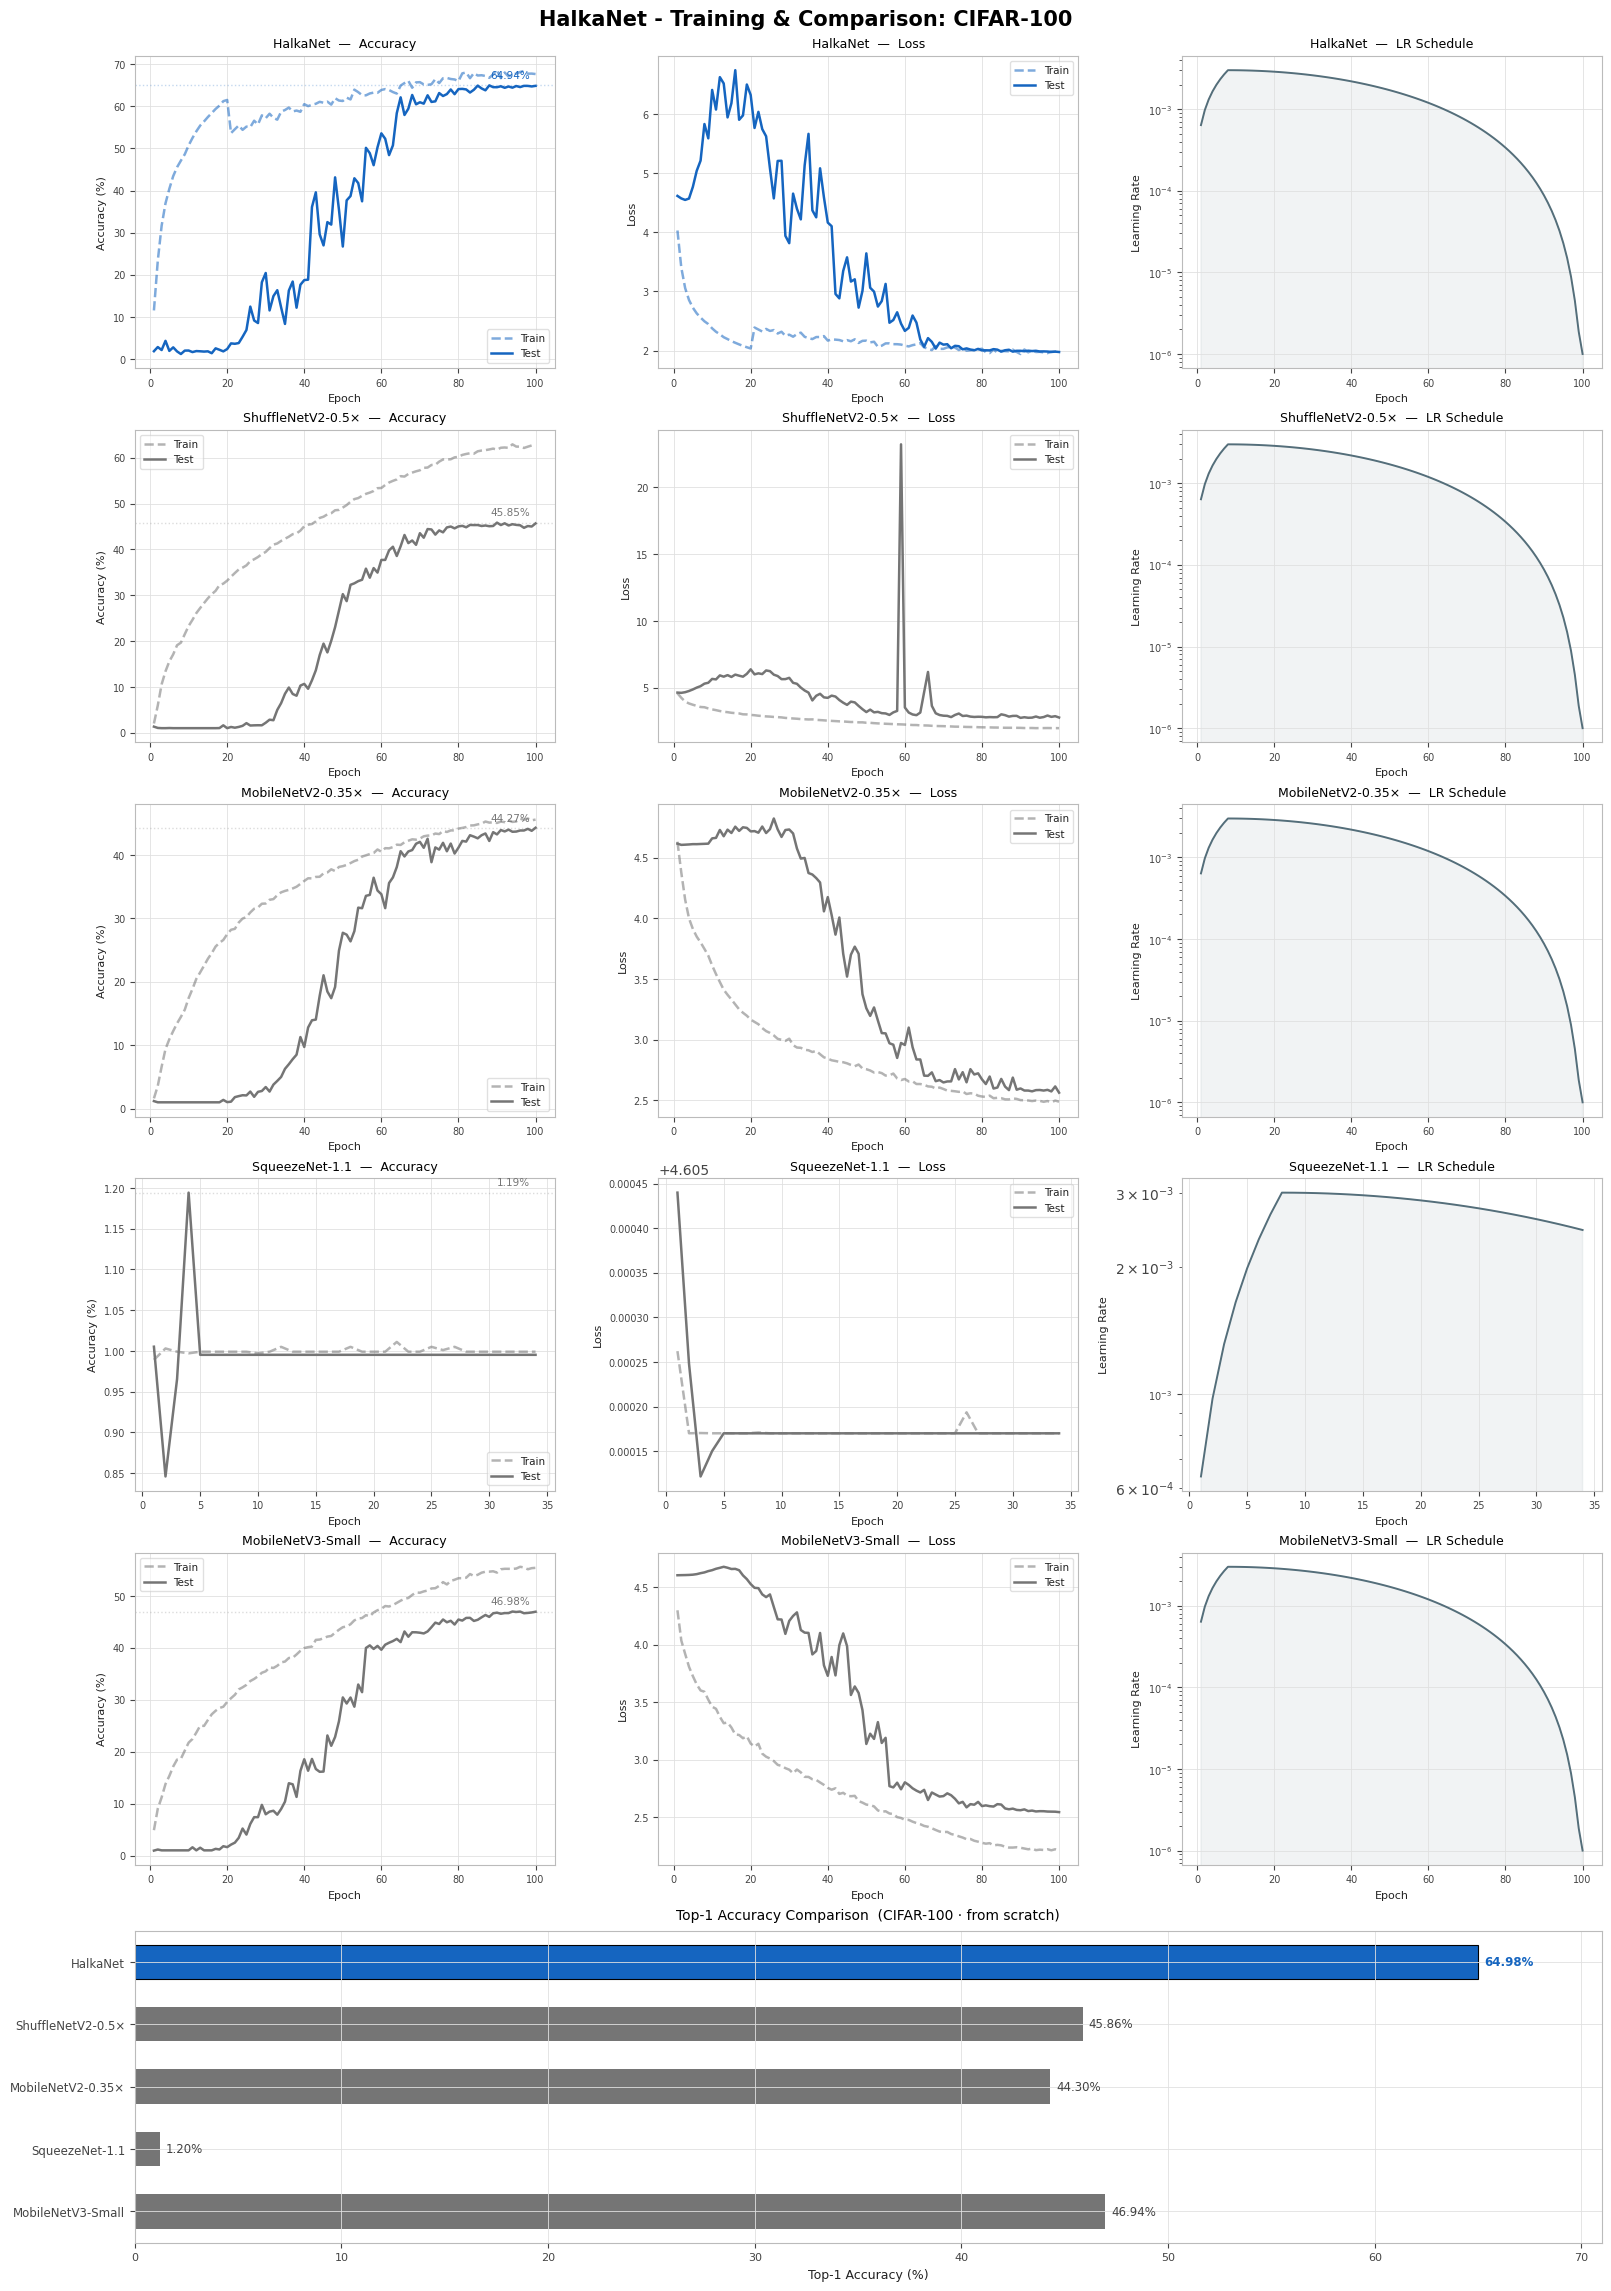

In [33]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/train_cifar100_32x32_comparision.pdf",
    dataset_name="CIFAR-100",
)